In [2]:
import pandas as pd
import numpy as np
GBQ_PROJECT_ID = '620265099307'

import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib import verbose
#verbose.level = 'helpful'      # one of silent, helpful, debug, debug-annoying

# taken from https://github.com/jrmontag/STLDecompose
# requires installation - pip install stldecompose
from stldecompose import decompose
# Simpler smoothing uses:
# from statsmodels.tsa.seasonal import seasonal_decompose

import geopandas as gpd

C:\Users\hcurtis\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Overall prescribing

## Import data

In [3]:
q = '''
SELECT
  p.practice,
  pct,
  prac.setting,
  p.month,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050113',items,0)) AS uti_items,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050103',items,0)) AS tetracyclines,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050108',items,0)) AS sulphonamides_trimethoprim,
  SUM(IF(SUBSTR(p.bnf_code,1,9)='0501013K0',items,0)) AS coamoxiclav,
  SUM(IF(SUBSTR(p.bnf_code,1,7)='0501021',items,0)) AS cephalosporins,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050112',items,0)) AS quinolones,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050105',items,0)) AS macrolides,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050111',items,0)) AS metroni_tini_ornidazole,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050101',items,0)) AS penicillins,
  SUM(IF(SUBSTR(p.bnf_code,1,9)='0501013K0' OR
         SUBSTR(p.bnf_code,1,7)='0501021' OR
         SUBSTR(p.bnf_code,1,6)='050112',items,0)) AS all_broad_spectrum,
  SUM(IF(SUBSTR(p.bnf_code,1,9)='0501013K0' OR
         SUBSTR(p.bnf_code,1,7)='0501021' OR
         SUBSTR(p.bnf_code,1,6) IN ('050112','050113','050103','050105','050111','050101'),items,0)) AS denom_broad_spectrum,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050110',items,0)) AS antileprotic,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050109',items,0)) AS antituberculosis,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050107',items,0)) AS some_other_antibacterials,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050104',items,0)) AS aminoglycosides,
  SUM(IF(SUBSTR(p.bnf_code,1,9) IN ('0501013C0','0501013F0','0501013E0','0501013B0'),items,0)) AS amoxicillin,
  SUM(items) AS items,
  SUM(IF((p.bnf_code like'0501130R0%AG' OR p.bnf_code like '0501130R0%AA' OR p.bnf_code like '0501130R0%AD' 
    OR p.bnf_code LIKE '0501015P0%AB' OR p.bnf_code LIKE '0501080W0%AE'), p.quantity,0) 
    * r.percent_of_adq) AS numerator_uti_course,
   SUM(IF((p.bnf_code like '0501130R0%AG' OR p.bnf_code like '0501130R0%AA' OR p.bnf_code like '0501130R0%AD'
    OR p.bnf_code like '0501015P0%AB' OR p.bnf_code LIKE '0501080W0%AE'), p.items,0)) AS denominator_uti_course,
  AVG(total_list_size) AS list_size,
  CAST(JSON_EXTRACT(MAX(star_pu), '$.oral_antibacterials_item') AS FLOAT64) AS star_pu_items
FROM
  ebmdatalab.alex.antibiotic_prescribing p
INNER JOIN
  ebmdatalab.hscic.practices prac
ON
  p.practice = prac.code
  AND (prac.setting = 4
  OR prac.setting = 2)
LEFT JOIN
  ebmdatalab.alex.practice_statistics_all_years_really stat
ON
  p.practice = stat.practice
  AND p.month = stat.month
LEFT JOIN
  ebmdatalab.hscic.presentation r
ON
  p.bnf_code = r.bnf_code
GROUP BY
  practice,
  pct,
  setting,
  month
ORDER BY
  practice,
  month
'''

all_antibiotics = pd.read_gbq(q, GBQ_PROJECT_ID, verbose=False, dialect='standard')
ooh = all_antibiotics.loc[all_antibiotics.setting==2]
all_antibiotics = all_antibiotics.loc[all_antibiotics.setting==4]
all_antibiotics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 698489 entries, 0 to 715285
Data columns (total 25 columns):
practice                      698489 non-null object
pct                           698489 non-null object
setting                       698489 non-null int32
month                         698489 non-null datetime64[ns]
uti_items                     698489 non-null int32
tetracyclines                 698489 non-null int32
sulphonamides_trimethoprim    698489 non-null int32
coamoxiclav                   698489 non-null int32
cephalosporins                698489 non-null int32
quinolones                    698489 non-null int32
macrolides                    698489 non-null int32
metroni_tini_ornidazole       698489 non-null int32
penicillins                   698489 non-null int32
all_broad_spectrum            698489 non-null int32
denom_broad_spectrum          698489 non-null int32
antileprotic                  698489 non-null int32
antituberculosis              698489 non-null 

In [4]:
pc = all_antibiotics.copy()

pc["percent_broad_spec"] = (pc.all_broad_spectrum/pc.denom_broad_spectrum).fillna(0)
# deal with nulls
pc["three_day_courses"] = (pc.numerator_uti_course/pc.denominator_uti_course).fillna(0)
pc = pc.drop(["all_broad_spectrum","denom_broad_spectrum","numerator_uti_course","denominator_uti_course"],axis=1)

for column in pc:
    if (pc[column].dtype == np.float64) | (pc[column].dtype == np.int32):
        pc["%s_per_thousand"%column] = pc[column]/(pc["list_size"]/1000)
    else:
        pc[column] = pc[column]
pc["items_per_starpu"] = pc["items"]/pc["star_pu_items"]
        
pc = pc.drop(["star_pu_items_per_thousand","percent_broad_spec_per_thousand","three_day_courses_per_thousand","list_size_per_thousand"],axis=1)
pc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 698489 entries, 0 to 715285
Data columns (total 40 columns):
practice                                   698489 non-null object
pct                                        698489 non-null object
setting                                    698489 non-null int32
month                                      698489 non-null datetime64[ns]
uti_items                                  698489 non-null int32
tetracyclines                              698489 non-null int32
sulphonamides_trimethoprim                 698489 non-null int32
coamoxiclav                                698489 non-null int32
cephalosporins                             698489 non-null int32
quinolones                                 698489 non-null int32
macrolides                                 698489 non-null int32
metroni_tini_ornidazole                    698489 non-null int32
penicillins                                698489 non-null int32
antileprotic                     

In [5]:
pc.practice.drop_duplicates().count()

8173

### Calculations and percentiles

In [6]:
# filter for normal practices
filtered = pc.copy().loc[(pc.list_size>1000) & (~pd.isnull(pc.star_pu_items)) & (pc["month"]>"2010-09-01") ]
filtered.head()

x1 = np.arange(0.1, 1, 0.1)
x2 = np.arange(0.01,0.1,0.01)
x3 = np.arange(0.91, 1, 0.01)
x = np.concatenate((x1,x2,x3))
pcf = filtered.groupby('month').quantile(x)
pcf = pcf.reset_index().rename(columns={"level_1": 'percentile'})
pcf.head(20)

month  percentile  aminogylcosides  aminogylcosides_per_thousand  \
0  2010-10-01        0.10              0.0                           0.0   
1  2010-10-01        0.20              0.0                           0.0   
2  2010-10-01        0.30              0.0                           0.0   
3  2010-10-01        0.40              0.0                           0.0   
4  2010-10-01        0.50              0.0                           0.0   
5  2010-10-01        0.60              0.0                           0.0   
6  2010-10-01        0.70              0.0                           0.0   
7  2010-10-01        0.80              0.0                           0.0   
8  2010-10-01        0.90              0.0                           0.0   
9  2010-10-01        0.01              0.0                           0.0   
10 2010-10-01        0.02              0.0                           0.0   
11 2010-10-01        0.03              0.0                           0.0   
12 2010-10-01        0.04              0.0                           0.0   
13 2010-10-01        0.05              0.0                           0.0   
14 2010-10-01        0.06              0.0                           0.0   
15 2010-10-01        0.07              0.0                           0.0   
16 2010-10-01        0.08              0.0                           0.0   
17 2010-10-01        0.09              0.0                           0.0   
18 2010-10-01        0.91              0.0                           0.0   
19 2010-10-01        0.92              0.0                           0.0   

    amoxicillin  amoxicillin_per_thousand  antileprotic  \
0          38.0                  9.722523           0.0   
1          54.0                 11.820060           0.0   
2          68.0                 13.374040           0.0   
3          83.0                 14.779781           0.0   
4          99.0                 16.226702           0.0   
5         118.0                 17.764899           0.0   
6         141.0                 19.792323           0.0   
7         169.0                 22.669650           0.0   
8         212.0                 27.275825           1.0   
9          14.0                  5.073234           0.0   
10         19.0                  6.465574           0.0   
11         22.0                  7.155841           0.0   
12         25.0                  7.697816           0.0   
13         28.0                  8.099332           0.0   
14         30.0                  8.610967           0.0   
15         32.0                  8.911060           0.0   
16         34.8                  9.222338           0.0   
17         36.0                  9.487929           0.0   
18        218.0                 28.012282           1.0   
19        226.0                 28.886390           1.0   

    antileprotic_per_thousand  antituberculosis  \
0                    0.000000               0.0   
1                    0.000000               0.0   
2                    0.000000               0.0   
3                    0.000000               0.0   
4                    0.000000               0.0   
5                    0.000000               0.0   
6                    0.000000               0.0   
7                    0.000000               1.0   
8                    0.149039               2.0   
9                    0.000000               0.0   
10                   0.000000               0.0   
11                   0.000000               0.0   
12                   0.000000               0.0   
13                   0.000000               0.0   
14                   0.000000               0.0   
15                   0.000000               0.0   
16                   0.000000               0.0   
17                   0.000000               0.0   
18                   0.160498               2.0   
19                   0.174234               2.0   

    antituberculosis_per_thousand           ...            \
0                        0.000000     

In [7]:
filtered.practice.drop_duplicates().count()

8052

## Practice level plots

### Without smoothing

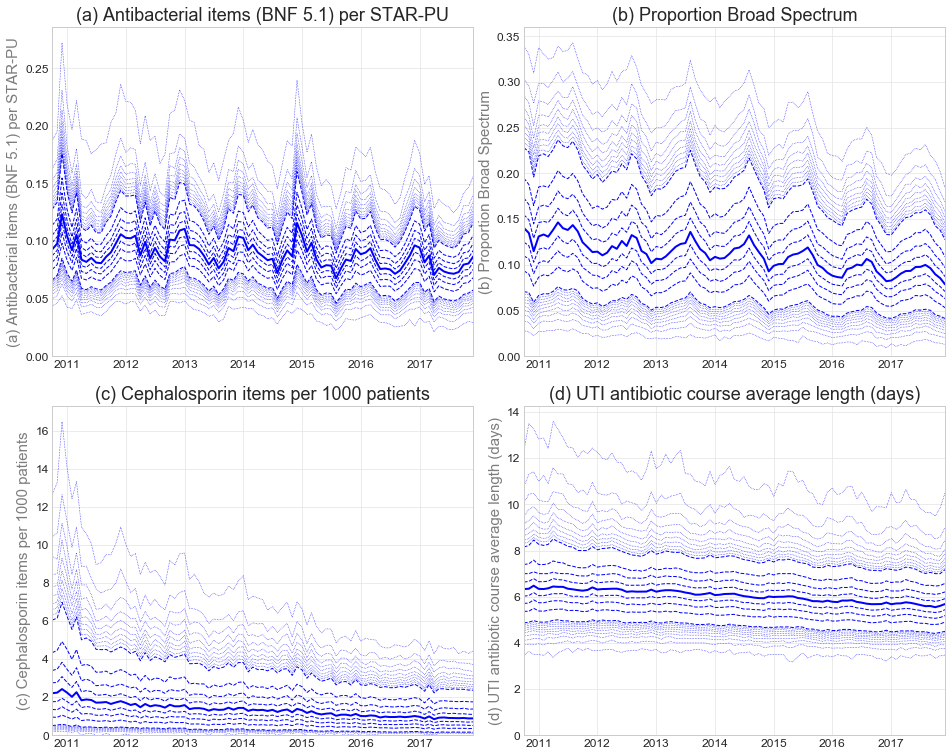

In [10]:
sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = pcf.sort_values(by=["month"])#,"drug"])
dfp['month'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month']]

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'items_per_starpu',0,0,'(a) Antibacterial items (BNF 5.1) per STAR-PU'), 
     (1,'percent_broad_spec',0,1,'(b) Proportion Broad Spectrum'),
     (2,'cephalosporins_per_thousand',1,0,'(c) Cephalosporin items per 1000 patients'),
     (3,'three_day_courses',1,1, '(d) UTI antibiotic course average length (days)')]
x = pd.Series(x)

fig = plt.figure(figsize=(16,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    for decile in x:   # plot each decile line
        data = dfp.loc[(dfp['percentile']==decile)]#(dfp['drug']==i[1]) & 
        if decile == .5:
            ax.plot(data["dates"],data[i[1]],'b-',linewidth=2)
        elif (decile <0.1) | (decile >0.9):
            ax.plot(data["dates"],data[i[1]],'b:',linewidth=0.6)
        else:
            #print (data)
            ax.plot(data["dates"],data[i[1]],'b--',linewidth=1)
    #if  i[3]%2==0:    # set y axis title only for charts in leftmost column
    ax.set_ylabel(i[4], size =15, alpha=0.6)
    ax.set_title(i[4],size = 18)
    ax.set_ylim([0, dfp[i[1]].max()*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range

plt.subplots_adjust(wspace = 0.12,hspace = 0.15)
plt.savefig('practice_deciles_no_smooth.png', format='png', dpi=300,bbox_inches='tight')
plt.show()

### WIth smoothing

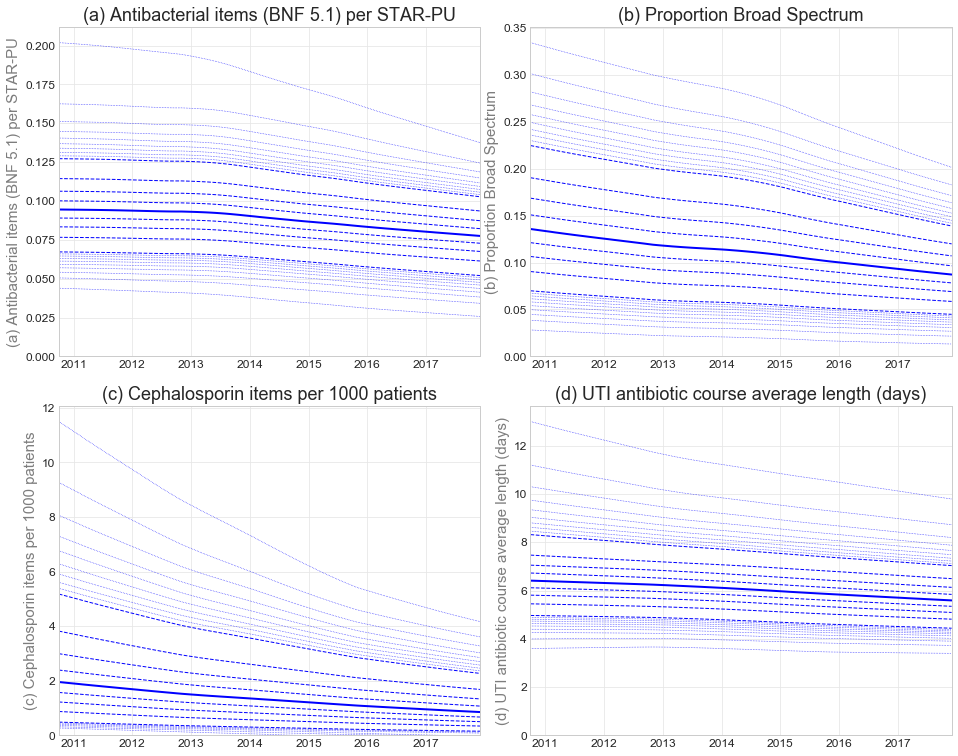

In [26]:
sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = pcf.sort_values(by=["month"])#,"drug"])
dfp['month_str'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month_str']]

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'items_per_starpu',0,0,'(a) Antibacterial items (BNF 5.1) per STAR-PU'), 
     (1,'percent_broad_spec',0,1,'(b) Proportion Broad Spectrum'),
     (2,'cephalosporins_per_thousand',1,0,'(c) Cephalosporin items per 1000 patients'),
     (3,'three_day_courses',1,1, '(d) UTI antibiotic course average length (days)')]
x = pd.Series(x)

fig = plt.figure(figsize=(16,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    for decile in x:   # plot each decile line
        data = dfp.loc[(dfp['percentile']==decile)]#(dfp['drug']==i[1]) & 
        #data.info()
        # for smoothing, dataframe needs to be non-missing and have a DateTime index
        #data = data.dropna()
        data = data.set_index('month')
        res = data[[i[1]]]
        #res = seasonal_decompose(res, model='additive') # cruder smoothing
        res = decompose(res, period=12, lo_frac=0.6, lo_delta=0.0)
        res = res.trend
        
        if decile == .5:
            ax.plot(data["dates"],res,'b-',linewidth=2)
        elif (decile <0.1) | (decile >0.9):
            ax.plot(data["dates"],res,'b:',linewidth=0.6)
        else:
            #print (data)
            ax.plot(data["dates"],res,'b--',linewidth=1)
    #if  i[3]%2==0:    # set y axis title only for charts in leftmost column
    ax.set_ylabel(i[4], size =15, alpha=0.6)
    ax.set_title(i[4],size = 18)
    ax.set_ylim([0, res.max()[0]*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range

plt.subplots_adjust(wspace = 0.12,hspace = 0.15)
plt.savefig('practice_deciles_smooth.png', format='png', dpi=300,bbox_inches='tight')
plt.show()

# OOH

In [81]:
pc_ooh = ooh.copy()

pc_ooh["percent_broad_spec"] = (pc_ooh.all_broad_spectrum/pc_ooh.denom_broad_spectrum).fillna(0)
# deal with nulls
pc_ooh["three_day_courses"] = (pc_ooh.numerator_uti_course/pc_ooh.denominator_uti_course).fillna(0)
pc_ooh = pc_ooh.drop(["all_broad_spectrum","denom_broad_spectrum","numerator_uti_course","denominator_uti_course"],axis=1)

for column in pc_ooh:
    if (pc_ooh[column].dtype == np.float64) | (pc_ooh[column].dtype == np.int32):
        pc_ooh["%s_per_thousand"%column] = pc_ooh[column]/(pc_ooh["list_size"]/1000)
    else:
        pc_ooh[column] = pc_ooh[column]
pc_ooh["items_per_starpu"] = pc_ooh["items"]/pc_ooh["star_pu_items"]
        
pc_ooh = pc_ooh.drop(["star_pu_items_per_thousand","percent_broad_spec_per_thousand","three_day_courses_per_thousand","list_size_per_thousand"],axis=1)

# filter for normal practices
filtered_ooh = pc_ooh.copy().loc[pc_ooh['items']>50]

x = np.arange(0.1, 1, 0.1)
#x2 = np.arange(0.01,0.1,0.01)
#x3 = np.arange(0.91, 1, 0.01)
#x = np.concatenate((x1,x2,x3))
pcf_ooh = filtered_ooh.groupby('month').quantile(x)
pcf_ooh = pcf_ooh.reset_index().rename(columns={"level_1": 'percentile'})
pcf_ooh.head(20)


pc_ooh.info()

C:\Users\Alex\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4406: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16809 entries, 27829 to 715297
Data columns (total 40 columns):
practice                                   16809 non-null object
pct                                        16809 non-null object
setting                                    16809 non-null int32
month                                      16809 non-null datetime64[ns]
uti_items                                  16809 non-null int32
tetracyclines                              16809 non-null int32
sulphonamides_trimethoprim                 16809 non-null int32
coamoxiclav                                16809 non-null int32
cephalosporins                             16809 non-null int32
quinolones                                 16809 non-null int32
macrolides                                 16809 non-null int32
metroni_tini_ornidazole                    16809 non-null int32
penicillins                                16809 non-null int32
antileprotic                               

In [82]:
filtered_ooh.practice.drop_duplicates().count()

260

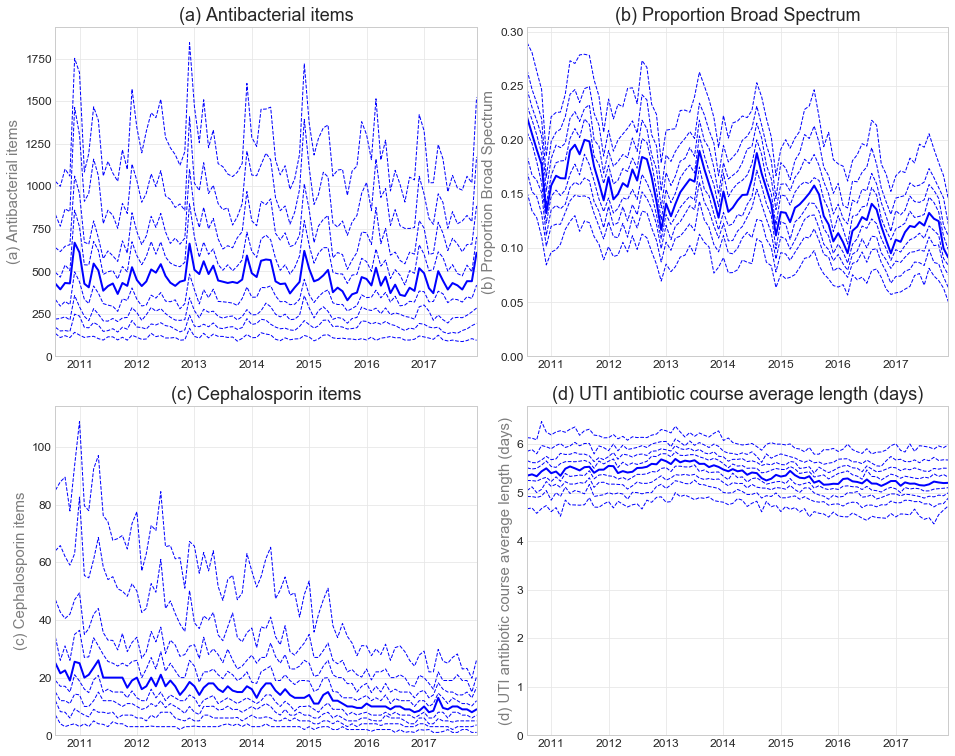

In [83]:
ooh#.head()
sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = pcf_ooh.sort_values(by=["month"])#,"drug"])
dfp['month_str'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month_str']]

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'items',0,0,'(a) Antibacterial items'), 
     (1,'percent_broad_spec',0,1,'(b) Proportion Broad Spectrum'),
     (2,'cephalosporins',1,0,'(c) Cephalosporin items'),
     (3,'three_day_courses',1,1, '(d) UTI antibiotic course average length (days)')]
x = pd.Series(x)

fig = plt.figure(figsize=(16,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    for decile in x:   # plot each decile line
        data = dfp.loc[(dfp['percentile']==decile)]#(dfp['drug']==i[1]) & 
        #data.info()
        # for smoothing, dataframe needs to be non-missing and have a DateTime index
        #data = data.dropna()
        data = data.set_index('month')
        res = data[[i[1]]]
        #res = seasonal_decompose(res, model='additive') # cruder smoothing
        #res = decompose(res, period=12, lo_frac=0.6, lo_delta=0.0)
        #res = res.trend
        
        if decile == .5:
            ax.plot(data["dates"],res,'b-',linewidth=2)
        elif (decile <0.1) | (decile >0.9):
            ax.plot(data["dates"],res,'b:',linewidth=0.6)
        else:
            #print (data)
            ax.plot(data["dates"],res,'b--',linewidth=1)
    #if  i[3]%2==0:    # set y axis title only for charts in leftmost column
    ax.set_ylabel(i[4], size =15, alpha=0.6)
    ax.set_title(i[4],size = 18)
    ax.set_ylim([0, res.max()[0]*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range

plt.subplots_adjust(wspace = 0.12,hspace = 0.15)
plt.savefig('practice_deciles_smooth.png', format='png', dpi=300,bbox_inches='tight')
plt.show()

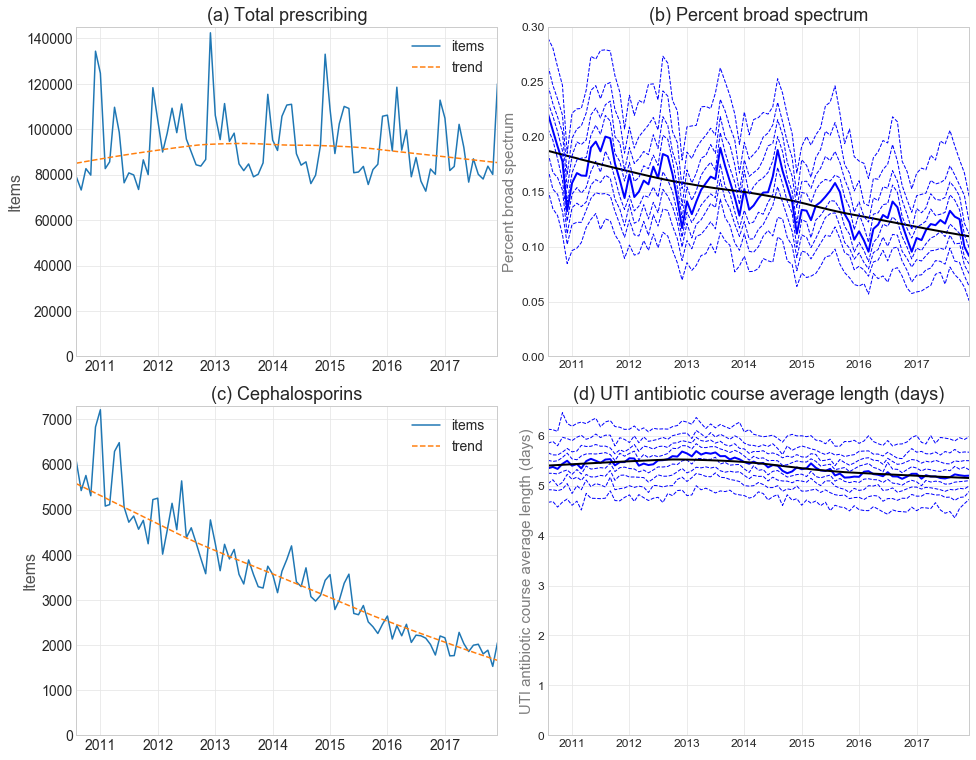

In [89]:
sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = pcf_ooh.sort_values(by=["month"])#,"drug"])
dfp['month_str'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month_str']]

fig = plt.figure(figsize=(16,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots


# for smoothing, dataframe needs to be non-missing and have a DateTime index
#data = data.dropna()
#data = ooh.loc[all_antibiotics["month"]>"2010-09-01"]
data = ooh.groupby('month').sum()[['items','list_size']]
data = pd.DataFrame(data['items'])

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
#calc.seasonal = (calc.seasonal/average)*100
flat = ((data-calc.trend))#/data)*100

ax = plt.subplot(gs[0,0])
ax.plot(data,label='items')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('Items', size =16, alpha=0.8)
ax.set_title('(a) Total prescribing',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
ax.set_ylim([0,145000])
ax.legend(prop={'size': 14})

'''ax = plt.subplot(gs[1,0])
ax.plot(flat,label='actual seasonality')
ax.plot(calc.seasonal,'g--',label='mean seasonality')
ax.axhline(0,color='black')
ax.set_ylabel('Change in items', size =16, alpha=0.8)
ax.set_title('(b) Seasonal variation in total prescribing',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
#ax.set_ylim([0,0.035])
ax.legend(prop={'size': 14})
plt.savefig('seasonal_variation_total.png', format='png', dpi=300,bbox_inches='tight')
plt.show()
'''
###########
ax = plt.subplot(gs[0,1])  # position of subplot in grid using coordinates listed in s
for decile in x:   # plot each decile line
    data = dfp.loc[(dfp['percentile']==decile)]#(dfp['drug']==i[1]) & 
    # for smoothing, dataframe needs to be non-missing and have a DateTime index
    #data = data.dropna()
    data = data.set_index('month')
    res = data['percent_broad_spec']
    #res = seasonal_decompose(res, model='additive') # cruder smoothing
    #res = decompose(res, period=12, lo_frac=0.6, lo_delta=0.0)
    #res = res.trend

    if decile == .5:
        ax.plot(data["dates"],res,'b-',linewidth=2)
        res = decompose(res, period=12, lo_frac=0.6, lo_delta=0.0)
        res = res.trend
        ax.plot(data["dates"],res,'k-',linewidth=2)
    elif (decile <0.1) | (decile >0.9):
        ax.plot(data["dates"],res,'b:',linewidth=0.6)
    else:
        ax.plot(data["dates"],res,'b--',linewidth=1)
ax.set_ylabel('Percent broad spectrum', size =15, alpha=0.6)
ax.set_title('(b) Percent broad spectrum',size = 18)
ax.set_ylim([0, 0.3])  # set ymax across all subplots as largest value across dataset
ax.tick_params(labelsize=12)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range

##########
ax = plt.subplot(gs[1,0])
data = ooh.groupby('month').sum()[['cephalosporins','list_size']]
data = pd.DataFrame(data['cephalosporins'])

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
#calc.seasonal = (calc.seasonal/average)*100
flat = ((data-calc.trend))#/data)*100

ax.plot(data,label='items')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('Items', size =16, alpha=0.8)
ax.set_title('(c) Cephalosporins',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
ax.set_ylim([0,7300])
ax.legend(prop={'size': 14})

###########
ax = plt.subplot(gs[1,1])  # position of subplot in grid using coordinates listed in s
for decile in x:   # plot each decile line
    data = dfp.loc[(dfp['percentile']==decile)]#(dfp['drug']==i[1]) & 
    # for smoothing, dataframe needs to be non-missing and have a DateTime index
    #data = data.dropna()
    data = data.set_index('month')
    res = data['three_day_courses']
    #res = seasonal_decompose(res, model='additive') # cruder smoothing
    #res = decompose(res, period=12, lo_frac=0.6, lo_delta=0.0)
    #res = res.trend

    if decile == .5:
        ax.plot(data["dates"],res,'b-',linewidth=2)
        res = decompose(res, period=12, lo_frac=0.6, lo_delta=0.0)
        res = res.trend
        ax.plot(data["dates"],res,'k-',linewidth=2)
    elif (decile <0.1) | (decile >0.9):
        ax.plot(data["dates"],res,'b:',linewidth=0.6)
    else:
        ax.plot(data["dates"],res,'b--',linewidth=1)
ax.set_ylabel('UTI antibiotic course average length (days)', size =15, alpha=0.6)
ax.set_title('(d) UTI antibiotic course average length (days)',size = 18)
ax.set_ylim([0, 6.6])  # set ymax across all subplots as largest value across dataset
ax.tick_params(labelsize=12)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range

plt.subplots_adjust(wspace = 0.12,hspace = 0.15)
plt.savefig('practice_deciles_smooth.png', format='png', dpi=300,bbox_inches='tight')
plt.show()

## CCG level

In [400]:
# remove practices with no STAR-PU
pc_ccg =  all_antibiotics.copy().loc[~pd.isnull(all_antibiotics.star_pu_items) & (all_antibiotics["month"]>"2010-09-01") ]
# group to CCGs
pc_ccg = pc_ccg.groupby(['pct','month'],as_index=False).sum()

pc_ccg["percent_broad_spec"] = (pc_ccg.all_broad_spectrum/pc_ccg.denom_broad_spectrum).fillna(0)
# deal with nulls
pc_ccg["three_day_courses"] = (pc_ccg.numerator_uti_course/pc_ccg.denominator_uti_course).fillna(0)
pc_ccg = pc_ccg.drop(["all_broad_spectrum","denom_broad_spectrum","numerator_uti_course","denominator_uti_course"],axis=1)

for column in pc_ccg:
    if (pc_ccg[column].dtype == np.float64) | (pc_ccg[column].dtype == np.int32):
        pc_ccg["%s_per_thousand"%column] = pc_ccg[column]/(pc["list_size"]/1000)
    else:
        pc_ccg[column] = pc_ccg[column]
pc_ccg["items_per_starpu"] = pc_ccg["items"]/pc_ccg["star_pu_items"]

pc_ccg = pc_ccg.groupby('month').quantile(x)
pc_ccg = pc_ccg.reset_index().rename(columns={"level_1": 'percentile'})

pc_ccg.head(9)

month  percentile  actual_cost  actual_cost_per_thousand  \
0 2010-10-01         0.1     1591.278               1300.477421   
1 2010-10-01         0.2    27428.062               4773.310251   
2 2010-10-01         0.3    35292.229               7292.125651   
3 2010-10-01         0.4    42312.710              10493.478660   
4 2010-10-01         0.5    48229.270              12549.477032   
5 2010-10-01         0.6    53418.376              17269.614564   
6 2010-10-01         0.7    61159.227              22553.293443   
7 2010-10-01         0.8    69447.044              33772.272297   
8 2010-10-01         0.9    89203.479              64267.440631   

   aminogylcosides  aminogylcosides_per_thousand  amoxicillin  \
0              0.0                      0.000000        137.2   
1              0.0                      0.000000       2183.6   
2              1.0                      0.206847       2638.7   
3              1.0                      0.372024       3076.8   
4              2.0                      0.631313       3663.0   
5              3.0                      0.862069       4340.6   
6              4.0                      1.219512       4945.5   
7              5.0                      1.876173       5526.4   
8              8.0                      4.081633       6808.0   

   amoxicillin_per_thousand  antileprotic  antileprotic_per_thousand  \
0                 88.967573           0.0                   0.043300   
1                351.417726           3.0                   0.644653   
2                515.179612           5.0                   0.940618   
3                816.434509           7.0                   1.586271   
4                975.971034           9.0                   2.199978   
5               1308.450802          10.0                   2.926886   
6               1718.470137          11.1                   4.064482   
7               2589.065683          15.0                   6.457498   
8               4480.515185          19.7                  12.739247   

            ...            star_pu_items  star_pu_items_per_thousand  \
0           ...              3121.090068                 2728.617589   
1           ...             70507.214552                12407.329711   
2           ...             92192.588198                18310.678872   
3           ...            107201.957923                24629.145208   
4           ...            119229.344369                32963.078720   
5           ...            136326.700801                41958.124907   
6           ...            154394.486686                56406.160788   
7           ...            178267.333735                84062.476366   
8           ...            232987.761724               151246.584298   

   sulphonamides_trimethoprim  sulphonamides_trimethoprim_per_thousand  \
0                        38.0                                25.591926   
1                       640.8                               114.687775   
2                       835.0                               181.656947   
3                       933.6                               231.217369   
4                      1105.5                               305.776173   
5                      1226.8                               370.364910   
6                      1503.8                               542.244305   
7                      1788.2                               909.336285   
8                      2330.6                              1498.262006   

   tetracyclines  tetracyclines_per_thousand  three_day_courses  \
0           39.2                   33.545253           5.642266   
1          600.4                  109.527456           5.972369   
2          711.0                  165.931423           6.148594   
3          844.8                  212.657456           6.280731   
4          987.5                  288.020391           6.417230   
5         1127.4                  361.474163           6.522719   
6         1357.4                 

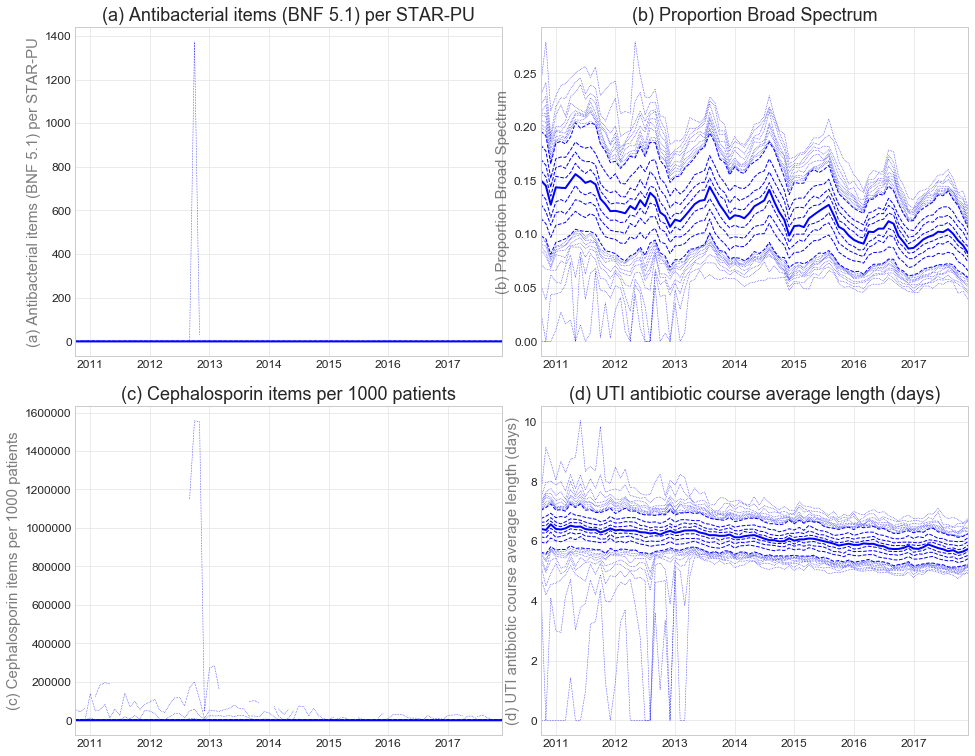

In [401]:
dfp = pc_ccg.sort_values(by=["month"])#,"drug"])
dfp['month'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month']]
x = pd.Series(x)

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'items_per_starpu',0,0,'(a) Antibacterial items (BNF 5.1) per STAR-PU'), 
     (1,'percent_broad_spec',0,1,'(b) Proportion Broad Spectrum'),
     (2,'cephalosporins_per_thousand',1,0,'(c) Cephalosporin items per 1000 patients'),
     (3,'three_day_courses',1,1, '(d) UTI antibiotic course average length (days)')]

fig = plt.figure(figsize=(16,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    for decile in x:   # plot each decile line
        data = dfp.loc[(dfp['percentile']==decile)]#(dfp['drug']==i[1]) & 
        if decile == .5:
            ax.plot(data["dates"],data[i[1]],'b-',linewidth=2)
        elif (decile <0.1) | (decile >0.9):
            ax.plot(data["dates"],data[i[1]],'b:',linewidth=0.6)
        else:
            #print (data)
            ax.plot(data["dates"],data[i[1]],'b--',linewidth=1)
    ax.set_ylabel(i[4], size =15, alpha=0.6)
    ax.set_title(i[4],size = 18)
    #ax.set_ylim([0, dfp[i[1]].max()*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range

plt.subplots_adjust(wspace = 0.09,hspace = 0.15)
#plt.savefig('ccg_deciles.png', format='png', dpi=300,bbox_inches='tight')

plt.show()

# MAPS

In [402]:
#aggregate over last year
ccg_last_year =  all_antibiotics.copy().loc[~pd.isnull(all_antibiotics.star_pu_items) & (all_antibiotics["month"] >'2016-12-01') ]

#ccg_last_year = all_antibiotics_ccg.loc[all_antibiotics_ccg.month]
ccg_last_year = ccg_last_year.groupby('pct').sum()
ccg_last_year["star_pu_items"] = ccg_last_year["star_pu_items"]/12
ccg_last_year["list_size"] = ccg_last_year["list_size"]/12

ccg_last_year["percent_broad_spec"] = (ccg_last_year.all_broad_spectrum/ccg_last_year.denom_broad_spectrum).fillna(0)
# deal with nulls
ccg_last_year["three_day_courses"] = (ccg_last_year.numerator_uti_course/ccg_last_year.denominator_uti_course).fillna(0)
ccg_last_year = ccg_last_year.drop(["all_broad_spectrum","denom_broad_spectrum","numerator_uti_course","denominator_uti_course"],axis=1)

for column in ccg_last_year:
    if (ccg_last_year[column].dtype == np.float64) | (ccg_last_year[column].dtype == np.int32):
        ccg_last_year["%s_per_thousand"%column] = ccg_last_year[column]/(ccg_last_year["list_size"]/1000)
    else:
        ccg_last_year[column] = ccg_last_year[column]
ccg_last_year["items_per_starpu"] = ccg_last_year["items"]/ccg_last_year["star_pu_items"]

ccg_last_year = ccg_last_year.drop(["star_pu_items_per_thousand","percent_broad_spec_per_thousand","three_day_courses_per_thousand","list_size_per_thousand"],axis=1)

ccg_last_year.head()

uti_items  tetracyclines  sulphonamides_trimethoprim  coamoxiclav  \
pct                                                                      
00C       6697           9864                        6081         1343   
00D      24004          32867                       14716         3497   
00J      17170          27723                       13384         3747   
00K      16607          27896                       16922         4034   
00L      25305          40016                       19128         8336   

     cephalosporins  quinolones  macrolides  metroni_tini_ornidazole  \
pct                                                                    
00C            1544        1238        9725                     1147   
00D            3893        2601       25565                     4246   
00J            3871        2418       17354                     2946   
00K            6188        2555       21468                     4132   
00L            4080        2374       25575                     2696   

     penicillins  antileprotic        ...         penicillins_per_thousand  \
pct                                   ...                                    
00C        27268            60        ...                       252.662595   
00D        88248           340        ...                       303.015979   
00J        74381           231        ...                       289.529135   
00K        87080           139        ...                       293.755916   
00L        94218           373        ...                       293.616846   

     antileprotic_per_thousand  antituberculosis_per_thousand  \
pct                                                             
00C                   0.555954                       0.185318   
00D                   1.167453                       0.374272   
00J                   0.899171                       0.326971   
00K                   0.468903                       0.445289   
00L                   1.162401                       0.891278   

     some_other_antibacterials_per_thousand  aminogylcosides_per_thousand  \
pct                                                                         
00C                                4.401303                      0.055595   
00D                                4.789993                      0.051505   
00J                                4.931816                      0.089528   
00K                                2.722336                      0.026987   
00L                                4.384713                      0.183865   

     amoxicillin_per_thousand  items_per_thousand  actual_cost_per_thousand  \
pct                                                                           
00C                144.798239          594.852329               2839.527007   
00D                166.217903          680.663136               3348.125865   
00J                154.326530          626.951772               3254.137380   
00K                159.288707          622.419804               3153.426812   
00L                153.128393          672.537709               3127.558036   

     star_pu_cost_per_thousand  items_per_starpu  
pct                                               
00C               28276.676995          1.033214  
00D               28525.126934          1.172898  
00J               28272.214447          1.093240  
00K               27961.067290          1.096456  
00L               29386.295424          1.122583  

[5 rows x 39 columns]

In [403]:
# join to geographical data
map_data = ccg_last_year.reset_index()
names = pd.read_csv('ccg_for_map.csv')
names = names.rename(columns={"CCG17CDH":"code","CCG17NM":"name"})
map_data = map_data.merge(names[['code','name']],left_on="pct",right_on="code")
map_data['name'] = map_data['name'].str.upper()
map_data['name'] = map_data["name"].str.replace("&","AND")
map_data = map_data.set_index('name')
#map_data = map_data.round(0)
map_data.head() # 207 rows

pct  uti_items  tetracyclines  \
name                                                                            
NHS DARLINGTON CCG                              00C       6697           9864   
NHS DURHAM DALES, EASINGTON AND SEDGEFIELD CCG  00D      24004          32867   
NHS NORTH DURHAM CCG                            00J      17170          27723   
NHS HARTLEPOOL AND STOCKTON-ON-TEES CCG         00K      16607          27896   
NHS NORTHUMBERLAND CCG                          00L      25305          40016   

                                                sulphonamides_trimethoprim  \
name                                                                         
NHS DARLINGTON CCG                                                    6081   
NHS DURHAM DALES, EASINGTON AND SEDGEFIELD CCG                       14716   
NHS NORTH DURHAM CCG                                                 13384   
NHS HARTLEPOOL AND STOCKTON-ON-TEES CCG                              16922   
NHS NORTHUMBERLAND CCG                                               19128   

                                                coamoxiclav  cephalosporins  \
name                                                                          
NHS DARLINGTON CCG                                     1343            1544   
NHS DURHAM DALES, EASINGTON AND SEDGEFIELD CCG         3497            3893   
NHS NORTH DURHAM CCG                                   3747            3871   
NHS HARTLEPOOL AND STOCKTON-ON-TEES CCG                4034            6188   
NHS NORTHUMBERLAND CCG                                 8336            4080   

                                                quinolones  macrolides  \
name                                                                     
NHS DARLINGTON CCG                                    1238        9725   
NHS DURHAM DALES, EASINGTON AND SEDGEFIELD CCG        2601       25565   
NHS NORTH DURHAM CCG                                  2418       17354   
NHS HARTLEPOOL AND STOCKTON-ON-TEES CCG               2555       21468   
NHS NORTHUMBERLAND CCG                                2374       25575   

                                                metroni_tini_ornidazole  \
name                                                                      
NHS DARLINGTON CCG                                                 1147   
NHS DURHAM DALES, EASINGTON AND SEDGEFIELD CCG                     4246   
NHS NORTH DURHAM CCG                                               2946   
NHS HARTLEPOOL AND STOCKTON-ON-TEES CCG                            4132   
NHS NORTHUMBERLAND CCG                                             2696   

                                                penicillins  ...   \
name                                                         ...    
NHS DARLINGTON CCG                                    27268  ...    
NHS DURHAM DALES, EASINGTON AND SEDGEFIELD CCG        88248  ...    
NHS NORTH DURHAM CCG                                  74381  ...    
NHS HARTLEPOOL AND STOCKTON-ON-TEES CCG               87080  ...    
NHS NORTHUMBERLAND CCG                                94218  ...    

                                                antileprotic_per_thousand  \
name                                                                        
NHS DARLINGTON CCG                                               0.555954   
NHS DURHAM DALES, EASINGTON AND SEDGEFIELD CCG                   1.167453   
NHS NORTH DURHAM CCG                                             0.899171   
NHS HARTLEPOOL AND STOCKTON-ON-TEES CCG                          0.468903   
NHS NORTHUMBERLAND CCG                                           1.162401   

                                                antituberculosis_per_thousand  \
name                                                                            
NHS DARLINGTON CCG                                                   0.185318   
NHS DURHAM DALES, EASINGTON AND SEDGEFIELD CCG                     

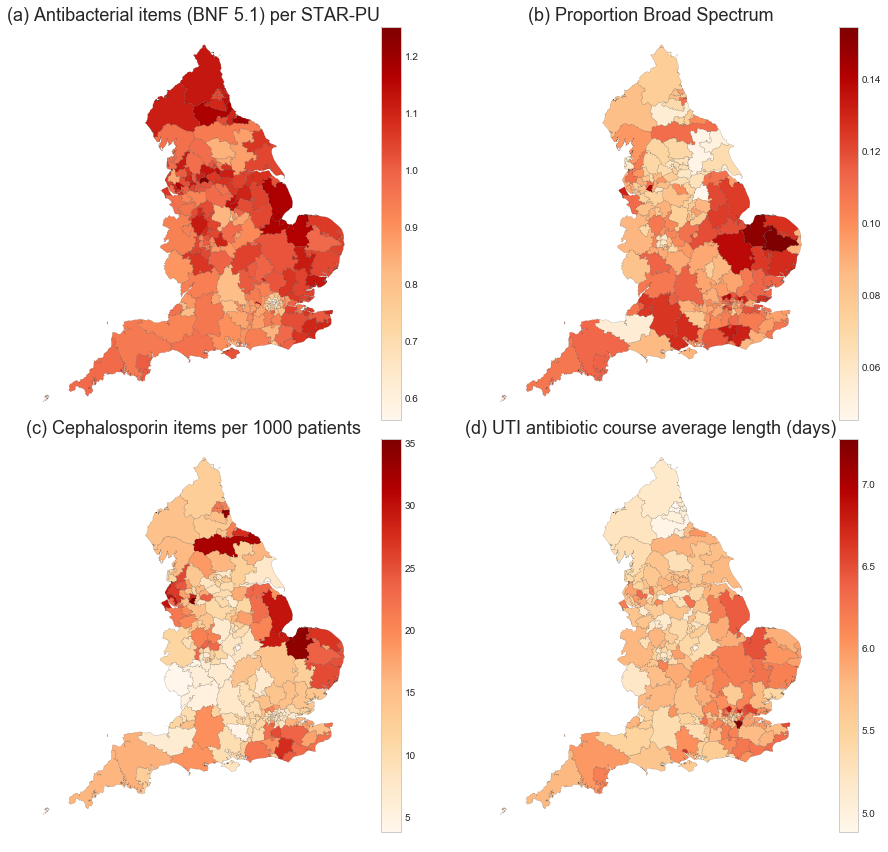

In [404]:
# from our API https://openprescribing.net/api/1.0/org_location/?org_type=ccg
ccgs = gpd.read_file('ccgs.json').set_index('name')

ccgs = ccgs[~ccgs['geometry'].isnull()]  # remove ones without geometry - these are federations rather than individual CCGs
gdf = ccgs.join(map_data)

# set sort order of measures manually, and add grid refs to position each subplot:
s = [(0,'items_per_starpu',0,0,'(a) Antibacterial items (BNF 5.1) per STAR-PU'), 
     (1,'percent_broad_spec',0,1,'(b) Proportion Broad Spectrum'),
     (2,'cephalosporins_per_thousand',1,0,'(c) Cephalosporin items per 1000 patients'),
     (3,'three_day_courses',1,1, '(d) UTI antibiotic course average length (days)')]

fig = plt.figure(figsize=(16,30))
gs = gridspec.GridSpec(4,2)  # grid layout for subplots

for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    gdf.plot(ax=ax,column=i[1],  edgecolor='black', linewidth=0.1, legend=True, cmap='OrRd')
    ax.set_aspect(1.63)
    ax.set_title(i[4],size = 18)
    plt.axis('off')

plt.subplots_adjust(wspace = 0.05,hspace = 0.05)
plt.savefig('maps.png', format='png', dpi=300,bbox_inches='tight')

plt.show()

## Seasonality

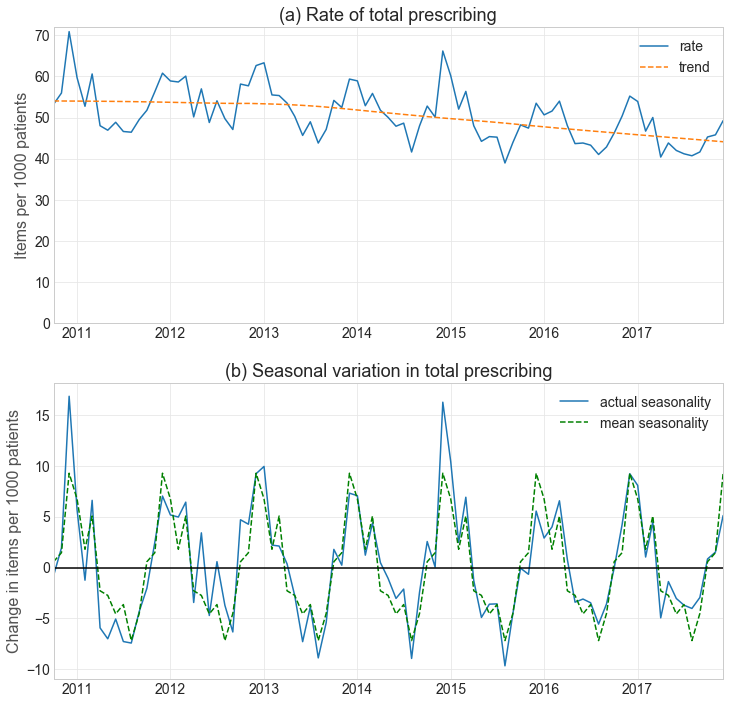

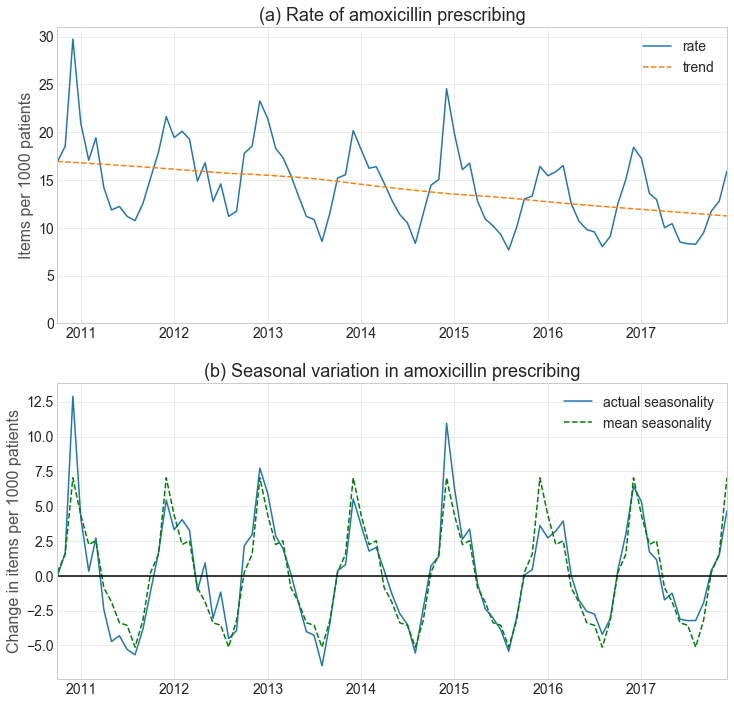

Typical amoxicillin seasonal variation 12.2 per 1000 patients


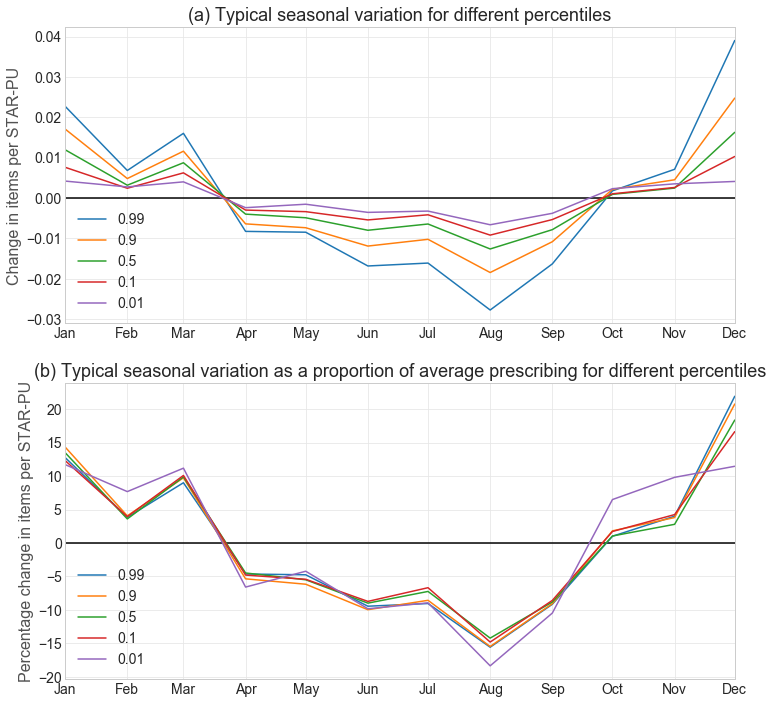

In [7]:
sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = pcf.sort_values(by=["month"])#,"drug"])
dfp['month_str'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month_str']]


'''
fig = plt.figure(figsize=(16,35)) 
gs = gridspec.GridSpec(5,1)  # grid layout for subplots

for i in s:
#for decile in [0.01,0.1,0.5,0.9,0.99]:
    ax = plt.subplot(gs[i[2], i[3]])
    data = dfp.loc[(round(dfp['percentile'],2)==i[4])]
    #data.info()
    # for smoothing, dataframe needs to be non-missing and have a DateTime index
    #data = data.dropna()
    data = data.set_index('month')


    calc = decompose(data[i[1]], period=12, lo_frac=0.6, lo_delta=0.0)
    #calc.plot()
    #plt.show()

    average = data.items_per_starpu.sum()/ (len(data.items_per_starpu))
    calc.seasonal = (calc.seasonal/average)*100
    flat = ((data.items_per_starpu-calc.trend)/data.items_per_starpu)*100
    #if decile == .5:
    #    ax.plot(data["dates"],res,'b-',linewidth=2)


    ax.plot(flat,label='actual seasonality')
    ax.plot(calc.seasonal,label='mean seasonality')
    ax.set_ylabel('Percentage change', size =16, alpha=0.8)
    ax.set_title('Percentile: %s'%(i[4]),size = 18)
    ax.tick_params(labelsize=14)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
    ax.set_ylim([-30,30])
    ax.legend(prop={'size': 14})


plt.show()'''
fig = plt.figure(figsize=(12,12)) 
gs = gridspec.GridSpec(2,1)  # grid layout for subplots


# for smoothing, dataframe needs to be non-missing and have a DateTime index
#data = data.dropna()
data = all_antibiotics.loc[all_antibiotics["month"]>"2010-09-01"]
data = data.groupby('month').sum()[['items','list_size']]
data = pd.DataFrame(data['items']/(data.list_size/1000))

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
#calc.seasonal = (calc.seasonal/average)*100
flat = ((data-calc.trend))#/data)*100

ax = plt.subplot(gs[0,0])
ax.plot(data,label='rate')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('Items per 1000 patients', size =16, alpha=0.8)
ax.set_title('(a) Rate of total prescribing',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
ax.set_ylim([0,72])
ax.legend(prop={'size': 14})

ax = plt.subplot(gs[1,0])
ax.plot(flat,label='actual seasonality')
ax.plot(calc.seasonal,'g--',label='mean seasonality')
ax.axhline(0,color='black')
ax.set_ylabel('Change in items per 1000 patients', size =16, alpha=0.8)
ax.set_title('(b) Seasonal variation in total prescribing',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
#ax.set_ylim([0,0.035])
ax.legend(prop={'size': 14})
plt.savefig('seasonal_variation_total.png', format='png', dpi=300,bbox_inches='tight')
plt.show()


fig = plt.figure(figsize=(12,12)) 
gs = gridspec.GridSpec(2,1)  # grid layout for subplots


# for smoothing, dataframe needs to be non-missing and have a DateTime index
#data = data.dropna()
data = all_antibiotics.loc[all_antibiotics["month"]>"2010-09-01"]
data = data.groupby('month').sum()[['amoxicillin','list_size']]
data = pd.DataFrame(data.amoxicillin/(data.list_size/1000))

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
#calc.seasonal = (calc.seasonal/average)*100
flat = ((data-calc.trend))#/data)*100

ax = plt.subplot(gs[0,0])
ax.plot(data,label='rate')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('Items per 1000 patients', size =16, alpha=0.8)
ax.set_title('(a) Rate of amoxicillin prescribing',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
ax.set_ylim([0,31])
ax.legend(prop={'size': 14})

ax = plt.subplot(gs[1,0])
ax.plot(flat,label='actual seasonality')
ax.plot(calc.seasonal,'g--',label='mean seasonality')
ax.axhline(0,color='black')
ax.set_ylabel('Change in items per 1000 patients', size =16, alpha=0.8)
ax.set_title('(b) Seasonal variation in amoxicillin prescribing',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
#ax.set_ylim([0,0.035])
ax.legend(prop={'size': 14})
plt.show()
print("Typical amoxicillin seasonal variation %s per 1000 patients"%(round(calc.seasonal[0].max()-calc.seasonal[0].min(),1)))

s = [(0,'items_per_starpu',0,0,0.99),
     (1,'items_per_starpu',1,0,0.9),
     (2,'items_per_starpu',2,0,0.5),
     (3,'items_per_starpu',3,0,0.1),
     (4,'items_per_starpu',4,0,0.01)]
fig = plt.figure(figsize=(12,12)) 
gs = gridspec.GridSpec(2,1)  # grid layout for subplots
ax = plt.subplot(gs[0,0])
ax.axhline(0,color='black')
ax2 = plt.subplot(gs[1,0])
ax2.axhline(0,color='black')
for i in s:
    data = dfp.loc[(round(dfp['percentile'],2)==i[4])]
    # for smoothing, dataframe needs to be non-missing and have a DateTime index
    #data = data.dropna()
    data = data.set_index('month')
    calc = decompose(data[i[1]], period=12, lo_frac=0.6, lo_delta=0.0)
    august = pd.DataFrame(data.items_per_starpu.reset_index().loc[pd.DatetimeIndex(data.reset_index()['month']).month==8])
    average = august.sum() / (len(august))
    average = data.items_per_starpu.sum()/ (len(data.items_per_starpu))
    minimum = calc.seasonal.min()
    
    ax.plot(calc.seasonal,label=i[4])
    ax.set_ylabel('Change in items per STAR-PU', size =16, alpha=0.8)
    ax.set_title('(a) Typical seasonal variation for different percentiles',size = 18)
    ax.tick_params(labelsize=14)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
    #ax.set_ylim([-20,25])
    ax.legend(prop={'size': 14})
    ax.set_xlim(['2017-01-01', dfp['dates'].max()]) # set x axis range as full date range
    bins = np.arange(1,14)
    ax.set_xticklabels([datetime.date(1900,i,1).strftime('%b') for i in bins[:-1]])
    
    calc.seasonal = (calc.seasonal / average) * 100
    
    ax2.plot(calc.seasonal,label=i[4])
    ax2.set_ylabel('Percentage change in items per STAR-PU', size =16, alpha=0.8)
    ax2.set_title('(b) Typical seasonal variation as a proportion of average prescribing for different percentiles',size = 18)
    ax2.tick_params(labelsize=14)
    ax2.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
    #ax2.set_ylim([-20,25])
    ax2.legend(prop={'size': 14})
    ax2.set_xlim(['2017-01-01', dfp['dates'].max()]) # set x axis range as full date range
    bins = np.arange(1,14)
    ax2.set_xticklabels([datetime.date(1900,i,1).strftime('%b') for i in bins[:-1]])
plt.show()

## Seasonality: 
### Aggregating into quarters & Measuring seasonality by summer prescribing level

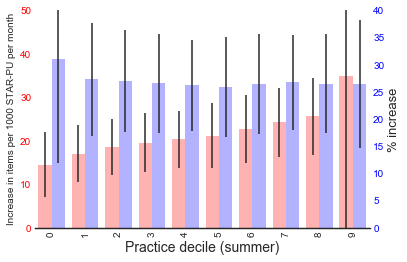

In [220]:
# practice-level data restricted to those with >1000 patients
qdf = all_antibiotics.copy()
qdf = qdf.loc[(qdf.list_size>1000) & (~pd.isnull(qdf.star_pu_items)) & (qdf["month"]>"2010-09-01") ]

# Assign months to seasons - use numbers so that decomposition function can recognise them as dates.
import datetime as dt
qdf["monthno"] = qdf.month.dt.month # extract month as a number
conditions = [
    (qdf['monthno']<=2 ),
    (qdf['monthno']<=5 ),
    (qdf['monthno']<=8 ),
    (qdf['monthno']<=11 )]
choices = [("01"),("04"),("07"),("10")]
qdf['season'] = np.select(conditions, choices, default="01")
qdf = qdf.drop(["monthno","setting"],axis=1)

# group data by season
qdf = qdf.groupby(['season',"practice"]).mean()
qdf = qdf.drop(["all_broad_spectrum","denom_broad_spectrum","numerator_uti_course","denominator_uti_course"],axis=1)

### overall prescribing rate to add as a line in table (not shown on chart)
qt = qdf.groupby(['season']).mean()
qt["items_per_starpu"] = 1000*qt["items"]/qt["star_pu_items"]
qt = qt.reset_index()[["season","items_per_starpu"]].set_index("season").transpose()
qt["winterpeak_abs"] = qt["01"]-qt["07"]
qt["winterpeak (%)"] = 100*qt["winterpeak_abs"]/qt["07"]
###

# calculate prescribing rate per 1,000 STAR-PU & rearrange data:
qdf["items_per_starpu"] = 1000*qdf["items"]/qdf["star_pu_items"]
qdf["amox_per_starpu"] = 1000*qdf["amoxicillin"]/qdf["star_pu_items"]
qdfa = qdf.copy()
qdfa = qdfa.reset_index()[["season","practice","amox_per_starpu"]].pivot(values="amox_per_starpu",columns="season",index="practice")

qdf = qdf.reset_index()[["season","practice","items_per_starpu"]].pivot(values="items_per_starpu",columns="season",index="practice")

# ignore practices where either summer or winter has no data:
qdf = qdf.loc[(pd.notnull(qdf["01"])) & (pd.notnull(qdf["07"]))] 

# assign practices to deciles for summer period; find their absolute and relative increase in prescribing in winter:
qdf["decile_summer"] = np.floor(qdf["07"].rank(pct=True)*10-0.00000001).astype(int)
qdf["winterpeak_abs"] = qdf["01"]-qdf["07"]
qdf["winterpeak (%)"] = 100*qdf["winterpeak_abs"]/qdf["07"]
qdf = qdf.reset_index()

# group to summer deciles and add standard deviation for error bars
o2 = qdf.groupby(["decile_summer"]).mean()
std = qdf.groupby(["decile_summer"])["winterpeak_abs","winterpeak (%)"].std()
std = std.rename(columns={"winterpeak_abs":"std","winterpeak (%)":"std (%)"})
o2 = pd.concat([o2,std],axis=1)

# Plot bar chart
sns.set_style("white")
width = 0.4
fig, ax = plt.subplots()

o2.plot(ax=ax,y="winterpeak_abs", color='r',linewidth=0,kind="bar", alpha=0.3,position=1, width=width,yerr="std",legend=False)
ax.set_xlabel('Practice decile (summer)',size=14)
ax2 =ax.twinx()
o2.plot(ax=ax2,y="winterpeak (%)", color='b',kind="bar", alpha=0.3,linewidth=0,position=0, width=width,yerr="std (%)",legend=False)
sns.despine(ax=ax, right=True, left=True)
sns.despine(ax=ax2, left=True, right=False)
ax2.spines['right'].set_color('white')

ax.set_xlim(-0.5,9.5)

ax.set_ylim(0,50)
ax2.set_ylim(0,40)

ax.set_ylabel('Increase in items per 1000 STAR-PU per month',size=10)
ax2.set_ylabel('% increase',size=13)
color_y_axis(ax, 'r')
color_y_axis(ax2, 'b')

plt.show()

#pd.concat([qdf,qt]).round(1)


### Amoxicillin seasonality

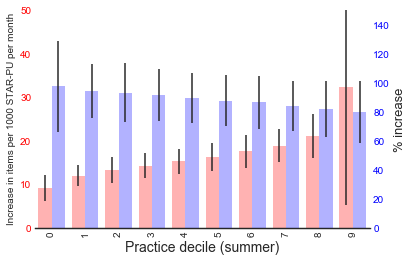

In [223]:
# ignore practices where either summer or winter has no data:
qdfa = qdfa.loc[(pd.notnull(qdfa["01"])) & (pd.notnull(qdfa["07"]))] 

# assign practices to deciles for summer period; find their absolute and relative increase in prescribing in winter:
qdfa["decile_summer"] = np.floor(qdfa["07"].rank(pct=True)*10-0.00000001).astype(int)
qdfa["winterpeak_abs"] = qdfa["01"]-qdfa["07"]
qdfa["winterpeak (%)"] = 100*qdfa["winterpeak_abs"]/qdfa["07"]
qdfa = qdfa.reset_index()

# group to summer deciles and add standard deviation for error bars
o2 = qdfa.groupby(["decile_summer"]).mean()
std = qdfa.groupby(["decile_summer"])["winterpeak_abs","winterpeak (%)"].std()
std = std.rename(columns={"winterpeak_abs":"std","winterpeak (%)":"std (%)"})
o2 = pd.concat([o2,std],axis=1)

# Plot bar chart
sns.set_style("white")
width = 0.4
fig, ax = plt.subplots()

o2.plot(ax=ax,y="winterpeak_abs", color='r',linewidth=0,kind="bar", alpha=0.3,position=1, width=width,yerr="std",legend=False)
ax.set_xlabel('Practice decile (summer)',size=14)
ax2 =ax.twinx()
o2.plot(ax=ax2,y="winterpeak (%)", color='b',kind="bar", alpha=0.3,linewidth=0,position=0, width=width,yerr="std (%)",legend=False)
sns.despine(ax=ax, right=True, left=True)
sns.despine(ax=ax2, left=True, right=False)
ax2.spines['right'].set_color('white')

ax.set_xlim(-0.5,9.5)

ax.set_ylim(0,50)
ax2.set_ylim(0,150)

ax.set_ylabel('Increase in items per 1000 STAR-PU per month',size=10)
ax2.set_ylabel('% increase',size=13)
color_y_axis(ax, 'r')
color_y_axis(ax2, 'b')

plt.show()

#pd.concat([qdfa,qt]).round(1)

# Additional plots for appendices

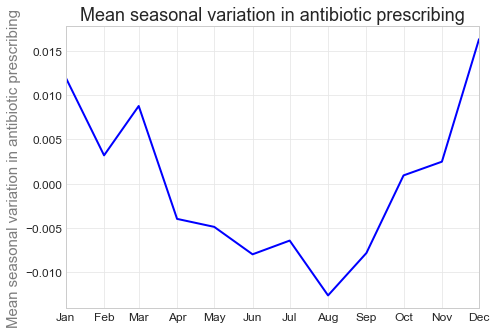

In [406]:
sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = pcf.sort_values(by=["month"])#,"drug"])
dfp['month_str'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month_str']]
#import calendar
#dfp['Month'] = pd.DatetimeIndex(dfp['month']).month
#dfp['Month'] = dfp['Month'].apply(lambda x: calendar.month_abbr[x])

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'items_per_starpu',0,0,'Mean seasonal variation in antibiotic prescribing')]
x = pd.Series(x)

fig = plt.figure(figsize=(16,35)) 
gs = gridspec.GridSpec(6,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    for decile in [0.5]:   # plot each decile line
        data = dfp.loc[(dfp['percentile']==decile)]#(dfp['drug']==i[1]) & 
        #data.info()
        # for smoothing, dataframe needs to be non-missing and have a DateTime index
        #data = data.dropna()
        data = data.set_index('month')
        res = data[[i[1]]]
        #res = seasonal_decompose(res, model='additive') # cruder smoothing
        res = decompose(res, period=12, lo_frac=0.6, lo_delta=0.0)
        res = res.seasonal
        
        if decile == .5:
            ax.plot(data["dates"],res,'b-',linewidth=2)
        elif (decile <0.1) | (decile >0.9):
            ax.plot(data["dates"],res,'b:',linewidth=0.6)
        else:
            #print (data)
            ax.plot(data["dates"],res,'b--',linewidth=1)
    #if  i[3]%2==0:    # set y axis title only for charts in leftmost column
    ax.set_ylabel(i[4], size =15, alpha=0.6)
    ax.set_title(i[4],size = 18)
    #ax.set_ylim([0, dfp[i[1]].max()*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim(['2017-01-01', dfp['dates'].max()]) # set x axis range as full date range
    bins = np.arange(1,14)
    ax.set_xticklabels([datetime.date(1900,i,1).strftime('%b') for i in bins[:-1]] )

plt.subplots_adjust(wspace = 0.16,hspace = 0.15)
plt.savefig('seasonal_variation.png', format='png', dpi=300,bbox_inches='tight')
plt.show()

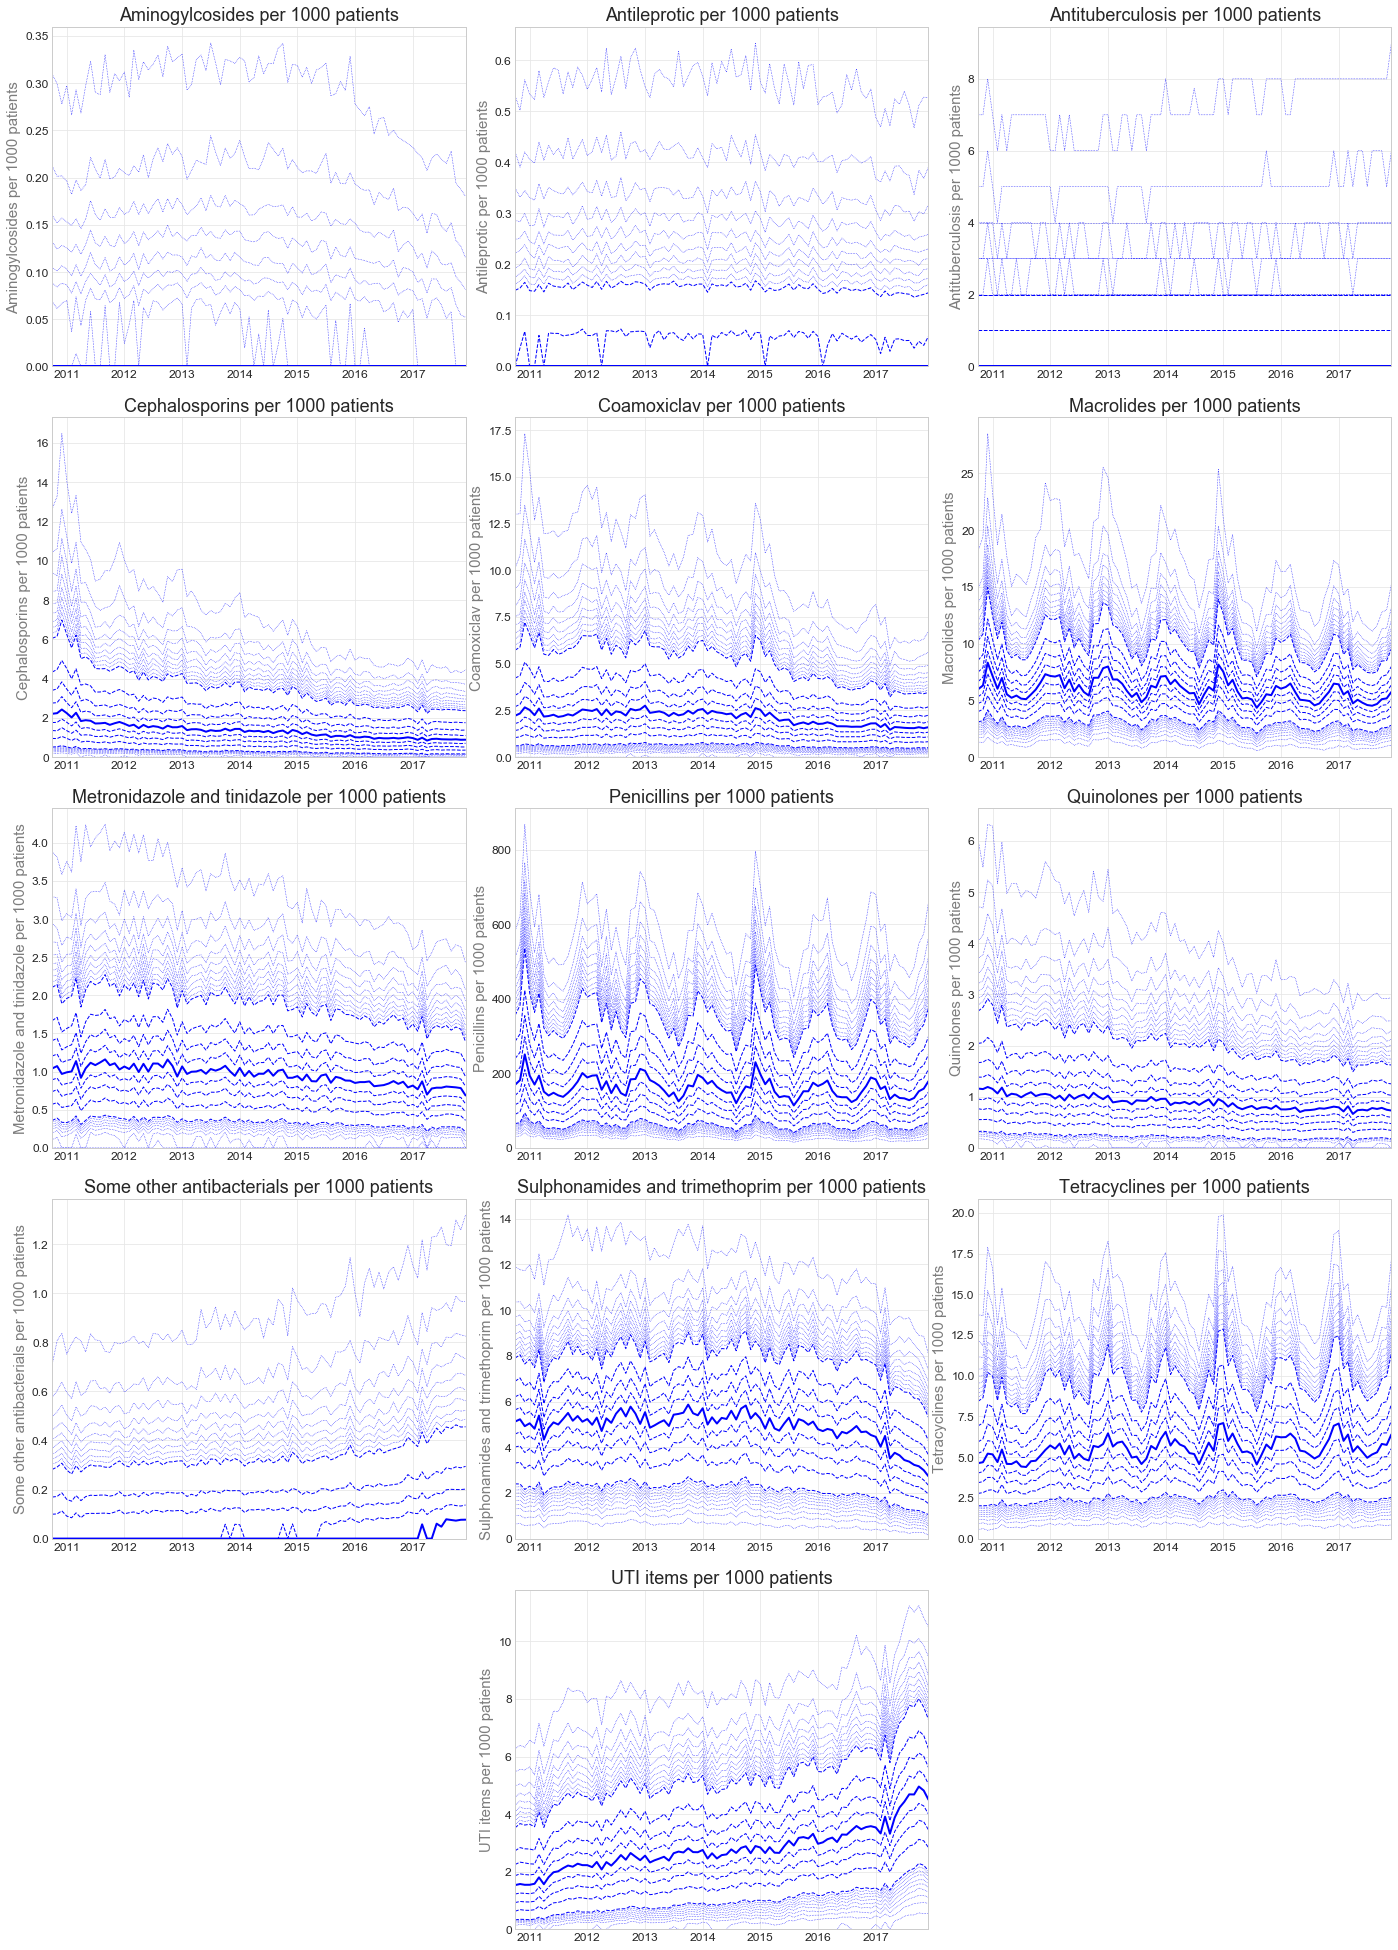

In [33]:
sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = pcf.sort_values(by=["month"])#,"drug"])
dfp['month_str'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month_str']]

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'aminoglycosides_per_thousand',0,0,'Aminoglycosides per 1000 patients'), 
     (1,'antileprotic_per_thousand',0,1,'Antileprotic per 1000 patients'),
     (2,'antituberculosis',0,2,'Antituberculosis per 1000 patients'),
     (3,'cephalosporins_per_thousand',1,0,'Cephalosporins per 1000 patients'),
     (4,'coamoxiclav_per_thousand',1,1, 'Coamoxiclav per 1000 patients'),
     (5,'macrolides_per_thousand',1,2, 'Macrolides per 1000 patients'),
     (6,'metroni_tini_ornidazole_per_thousand',2,0, 'Metronidazole and tinidazole per 1000 patients'),
     (7,'penicillins',2,1,'Penicillins per 1000 patients'),
     (8,'quinolones_per_thousand',2,2, 'Quinolones per 1000 patients'),
     (9,'some_other_antibacterials_per_thousand',3,0, 'Some other antibacterials per 1000 patients'),
     (10,'sulphonamides_trimethoprim_per_thousand',3,1, 'Sulphonamides and trimethoprim per 1000 patients'),
     (11,'tetracyclines_per_thousand',3,2, 'Tetracyclines per 1000 patients'),
     (12,'uti_items_per_thousand',4,1, 'UTI items per 1000 patients')
    ]
x = pd.Series(x)

fig = plt.figure(figsize=(24,35)) 
gs = gridspec.GridSpec(5,3)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    for decile in x:   # plot each decile line
        data = dfp.loc[(dfp['percentile']==decile)]#(dfp['drug']==i[1]) & 
        #data.info()
        # for smoothing, dataframe needs to be non-missing and have a DateTime index
        #data = data.dropna()
        data = data.set_index('month')
        res = data[[i[1]]]
        #res = seasonal_decompose(res, model='additive') # cruder smoothing
        #res = decompose(res, period=12, lo_frac=0.6, lo_delta=0.0)
        #res = res.trend
        
        if decile == .5:
            ax.plot(data["dates"],res,'b-',linewidth=2)
        elif (decile <0.1) | (decile >0.9):
            ax.plot(data["dates"],res,'b:',linewidth=0.6)
        else:
            #print (data)
            ax.plot(data["dates"],res,'b--',linewidth=1)
    #if  i[3]%2==0:    # set y axis title only for charts in leftmost column
    ax.set_ylabel(i[4], size =15, alpha=0.6)
    ax.set_title(i[4],size = 18)
    ax.set_ylim([0, dfp[i[1]].max()*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range

plt.subplots_adjust(wspace = 0.12,hspace = 0.15)
plt.savefig('practice_deciles_appendices.png', format='png', dpi=300,bbox_inches='tight')
plt.show()